In [1]:
!pip3 install pandas
!pip3 install networkx
!pip3 install matplotlib
!pip3 install seaborn

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.5 MB 1.3 MB/s eta 0:00:09
   --- ------------------------------------ 1.0/11.5 MB 1.3 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/11.5 MB 1.4 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/11.5 MB 1.5 MB/s eta 0:00:07
   -------- ------------------------------- 2.4/11.5 MB 1.6 MB/s eta 0:00:06
   --------- ------------------------------ 2.6/11.5 MB 1.7 MB/s eta 0:00:06
   ---------- ----------------------------- 3.1/11.5 MB 1.7 MB/s eta 0:00:05
   ------------ --------------------------- 3.7/11.5 MB 1.8 MB/s eta 0:00:05
   -------------- ------------------------- 4.2/11.5 MB 1.9 MB/s eta 0:00:04
   ---------------- ----------------------- 4.7/11.5 MB 2.0 MB/s eta 0:00:04
   -----------------

In [11]:
# UMLS Ontology Inconsistency Detector - .ipynb Code

# Cell 1: Imports and Setup
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [12]:
# Cell 2: Load and Preview the MRREL.RRF Data
file_path = "MRREL.RRF"
if not os.path.exists(file_path):
    raise FileNotFoundError("MRREL.RRF not found in the current directory. Please place the file alongside the notebook.")

mrrel_df = pd.read_csv(file_path, sep='|', header=None, dtype=str)
if mrrel_df.shape[1] > 16:
    mrrel_df = mrrel_df.iloc[:, :-1]

mrrel_df.columns = [
    "CUI1", "AUI1", "STYPE1", "REL", 
    "CUI2", "AUI2", "STYPE2", "RELA", 
    "RUI", "SRUI", "SAB", "SL", 
    "RG", "DIR", "SUPPRESS", "CVF"
]

print("Sample Rows:")
display(mrrel_df.head())

Sample Rows:


,CUI1,AUI1,STYPE1,REL,CUI2,AUI2,STYPE2,RELA,RUI,SRUI,SAB,SL,RG,DIR,SUPPRESS,CVF
0,C0000005,A26634265,SCUI,RB,C0036775,A0115649,SCUI,NaN,R31979041,NaN,MSH,MSH,NaN,NaN,N,NaN
1,C0000039,A0016515,AUI,SY,C0000039,A12091182,AUI,entry_version_of,R64592881,NaN,MSH,MSH,NaN,NaN,N,NaN
2,C0000039,A0016515,AUI,SY,C0000039,A1317708,AUI,permuted_term_of,R28482432,NaN,MSH,MSH,NaN,NaN,N,NaN
3,C0000039,A0016515,AUI,SY,C0000039,A7480660,AUI,translation_of,R206578450,NaN,MSHGER,MSHGER,NaN,NaN,N,NaN
4,C0000039,A0016515,SCUI,SY,C0000039,A28315139,SCUI,NaN,R179354458,NaN,MED-RT,MED-RT,NaN,Y,N,NaN


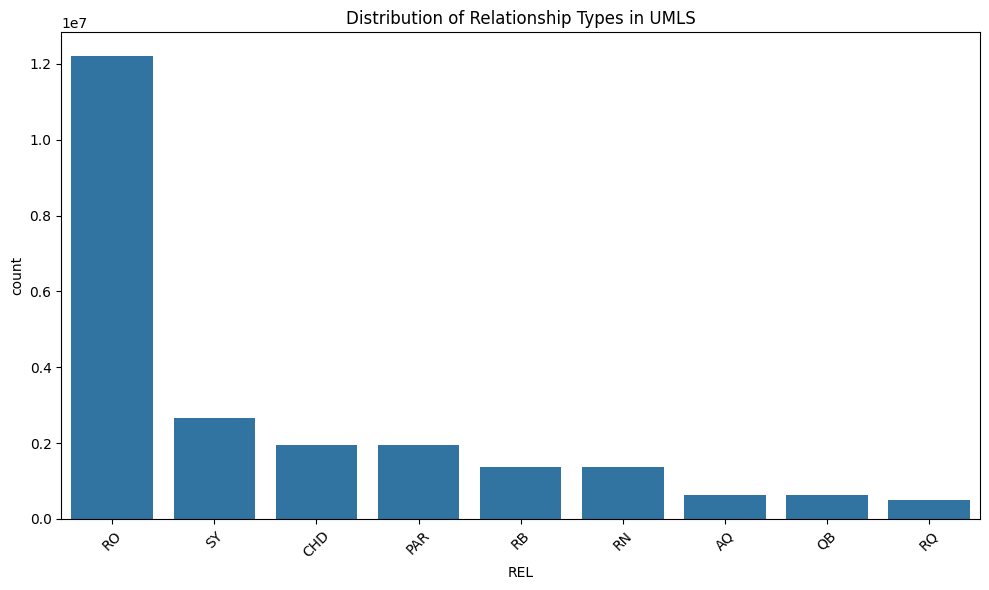

In [13]:
# Cell 3: Visualize Relationship Types
plt.figure(figsize=(10, 6))
sns.countplot(data=mrrel_df, x='REL', order=mrrel_df['REL'].value_counts().index)
plt.title("Distribution of Relationship Types in UMLS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Cell 4: Build Graphs for PAR and RB Relations
parent_graph = nx.DiGraph()
broader_graph = nx.DiGraph()

for _, row in mrrel_df.iterrows():
    if row['REL'] == 'PAR':
        parent_graph.add_edge(row['CUI2'], row['CUI1'])
    elif row['REL'] == 'RB':
        broader_graph.add_edge(row['CUI2'], row['CUI1'])

In [15]:
# Cell 5: Detect Parent-Child Loops
parent_cycles = list(nx.simple_cycles(parent_graph))
print(f"Parent-Child Cycles Found: {len(parent_cycles)}")
for cycle in parent_cycles[:5]:
    print(" -> ".join(cycle))

Parent-Child Cycles Found: 3283
C0000376
C0036720
C0018533
C0000473
C3653848


In [16]:
# Cell 6: Detect Broader-Than Conflicts
bt_conflicts = [(a, b) for a, b in broader_graph.edges() if broader_graph.has_edge(b, a)]
print(f"Broader-Than Conflicts Found: {len(bt_conflicts)}")
for conflict in bt_conflicts[:5]:
    print(f"Conflict: {conflict[0]} <-> {conflict[1]}")

Broader-Than Conflicts Found: 3917
Conflict: C0007090 <-> C0007090
Conflict: C0000334 <-> C0000334
Conflict: C0000376 <-> C0000376
Conflict: C0018533 <-> C0018533
Conflict: C0020388 <-> C0020388


In [17]:
# Cell 7: Export Results
pd.DataFrame(parent_cycles).to_csv("parent_child_loops.csv", index=False)
pd.DataFrame(bt_conflicts, columns=["Concept A", "Concept B"]).to_csv("broader_than_conflicts.csv", index=False)

summary = {
    "total_parent_edges": parent_graph.number_of_edges(),
    "total_broader_edges": broader_graph.number_of_edges(),
    "total_cycles": len(parent_cycles),
    "total_broader_than_conflicts": len(bt_conflicts)
}
with open("summary_stats.json", "w") as f:
    json.dump(summary, f, indent=2)

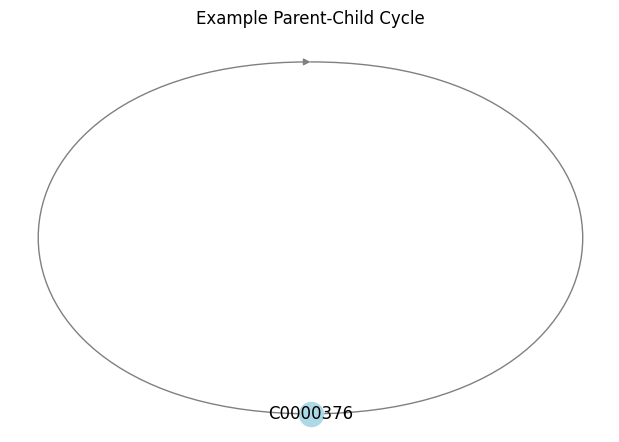

In [18]:
# Cell 8: Visualize Example Cycle
if parent_cycles:
    example_cycle = parent_cycles[0]
    cycle_graph = nx.DiGraph()
    edges = [(example_cycle[i], example_cycle[(i + 1) % len(example_cycle)]) for i in range(len(example_cycle))]
    cycle_graph.add_edges_from(edges)
    plt.figure(figsize=(6, 4))
    nx.draw(cycle_graph, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Example Parent-Child Cycle")
    plt.show()


In [19]:
# Cell 9: Summary Printout
print("\nSummary of Analysis:")
print(json.dumps(summary, indent=2))


Summary of Analysis:
{
  "total_parent_edges": 1842838,
  "total_broader_edges": 1278970,
  "total_cycles": 3283,
  "total_broader_than_conflicts": 3917
}


In [20]:
print("\n Analysis complete. Results saved as CSV and JSON files in the current directory.")


 Analysis complete. Results saved as CSV and JSON files in the current directory.


C:\Users\mytes\AppData\Local\Temp\ipykernel_3964\3086080705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sab_counts.values, y=sab_counts.index, palette="Blues_d")


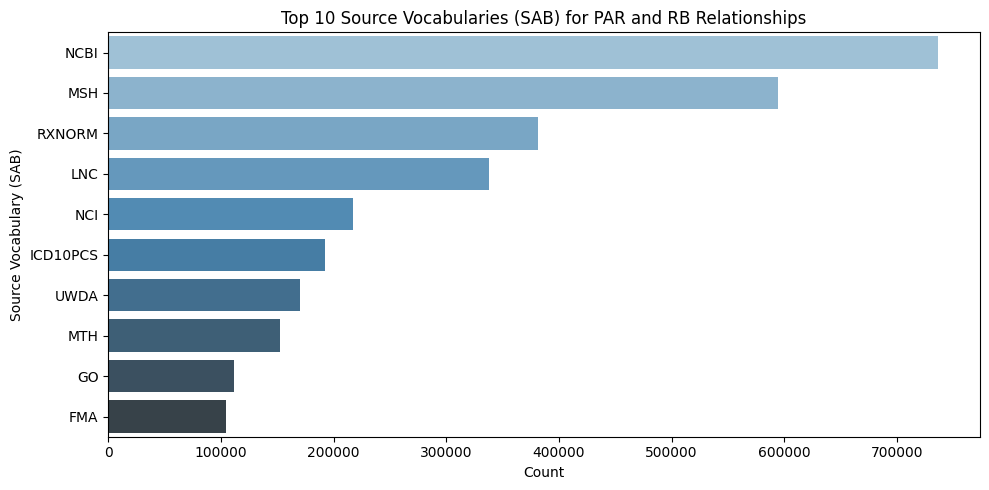

In [21]:
#counting the  most frequent SABs (sources) for PAR and RB relationships
sab_counts = mrrel_df[mrrel_df["REL"].isin(["PAR", "RB"])]["SAB"].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=sab_counts.values, y=sab_counts.index, palette="Blues_d")
plt.title("Top 10 Source Vocabularies (SAB) for PAR and RB Relationships")
plt.xlabel("Count")
plt.ylabel("Source Vocabulary (SAB)")
plt.tight_layout()
plt.show()


In [22]:
# to check the network density - Graph complexity stats
print("Graph Statistics:")

print(f"Parent Graph - Nodes: {parent_graph.number_of_nodes()}, Edges: {parent_graph.number_of_edges()}, Density: {nx.density(parent_graph):.6f}")
print(f"Broader Graph - Nodes: {broader_graph.number_of_nodes()}, Edges: {broader_graph.number_of_edges()}, Density: {nx.density(broader_graph):.6f}")

Graph Statistics:
Parent Graph - Nodes: 1559038, Edges: 1842838, Density: 0.000001
Broader Graph - Nodes: 877565, Edges: 1278970, Density: 0.000002


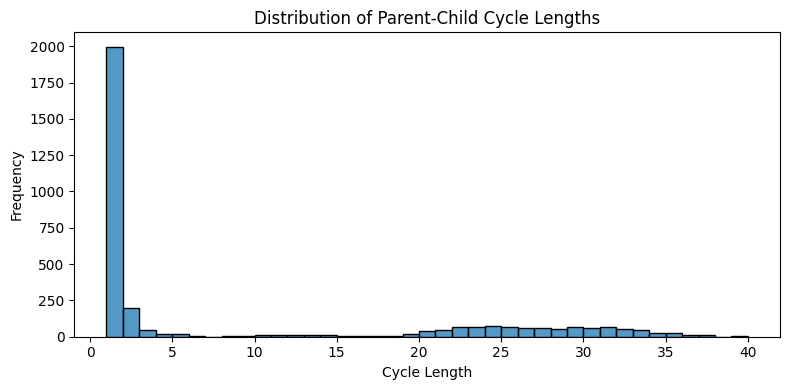

Shortest cycle: 1 nodes
Longest cycle: 39 nodes
Average cycle length: 8.74 nodes


In [23]:
# to check how deep are the loops
cycle_lengths = [len(cycle) for cycle in parent_cycles]

plt.figure(figsize=(8, 4))
sns.histplot(cycle_lengths, bins=range(1, max(cycle_lengths)+2), kde=False)
plt.title("Distribution of Parent-Child Cycle Lengths")
plt.xlabel("Cycle Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

if cycle_lengths:
    print(f"Shortest cycle: {min(cycle_lengths)} nodes")
    print(f"Longest cycle: {max(cycle_lengths)} nodes")
    print(f"Average cycle length: {sum(cycle_lengths)/len(cycle_lengths):.2f} nodes")
else:
    print("No cycles found, so no length distribution.")


C:\Users\mytes\AppData\Local\Temp\ipykernel_3964\4007497000.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sab_conflicts.values, y=top_sab_conflicts.index, palette="Reds_d")


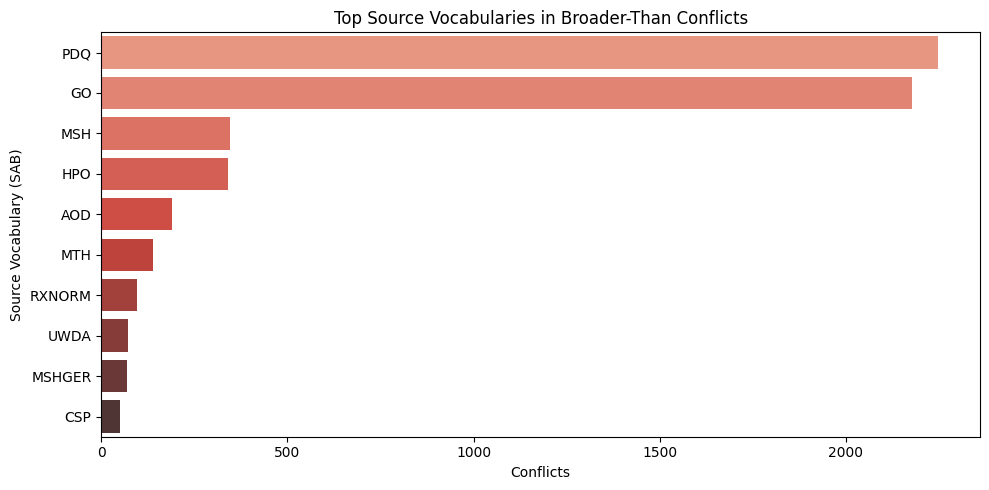

In [24]:
#broader than conflicts by source vocabulary - merging SAB info for conflicting pairs
conflict_df = pd.DataFrame(bt_conflicts, columns=["CUI_A", "CUI_B"])
merged_a = mrrel_df[["CUI1", "CUI2", "REL", "SAB"]][mrrel_df["REL"] == "RB"]
merged_both = conflict_df.merge(merged_a, left_on=["CUI_A", "CUI_B"], right_on=["CUI1", "CUI2"], how="left")

top_sab_conflicts = merged_both["SAB"].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_sab_conflicts.values, y=top_sab_conflicts.index, palette="Reds_d")
plt.title("Top Source Vocabularies in Broader-Than Conflicts")
plt.xlabel("Conflicts")
plt.ylabel("Source Vocabulary (SAB)")
plt.tight_layout()
plt.show()

In [26]:
print(" Final Analysis Summary")
print(f"Total parent-child relationships (PAR): {summary['total_parent_edges']}")
print(f"Total broader-than relationships (RB): {summary['total_broader_edges']}")
print(f"Detected parent-child cycles: {summary['total_cycles']}")
print(f"Detected broader-than conflicts: {summary['total_broader_than_conflicts']}")
print("\nAnalysis complete — results and visualizations generated successfully!")


 Final Analysis Summary
Total parent-child relationships (PAR): 1842838
Total broader-than relationships (RB): 1278970
Detected parent-child cycles: 3283
Detected broader-than conflicts: 3917

Analysis complete — results and visualizations generated successfully!


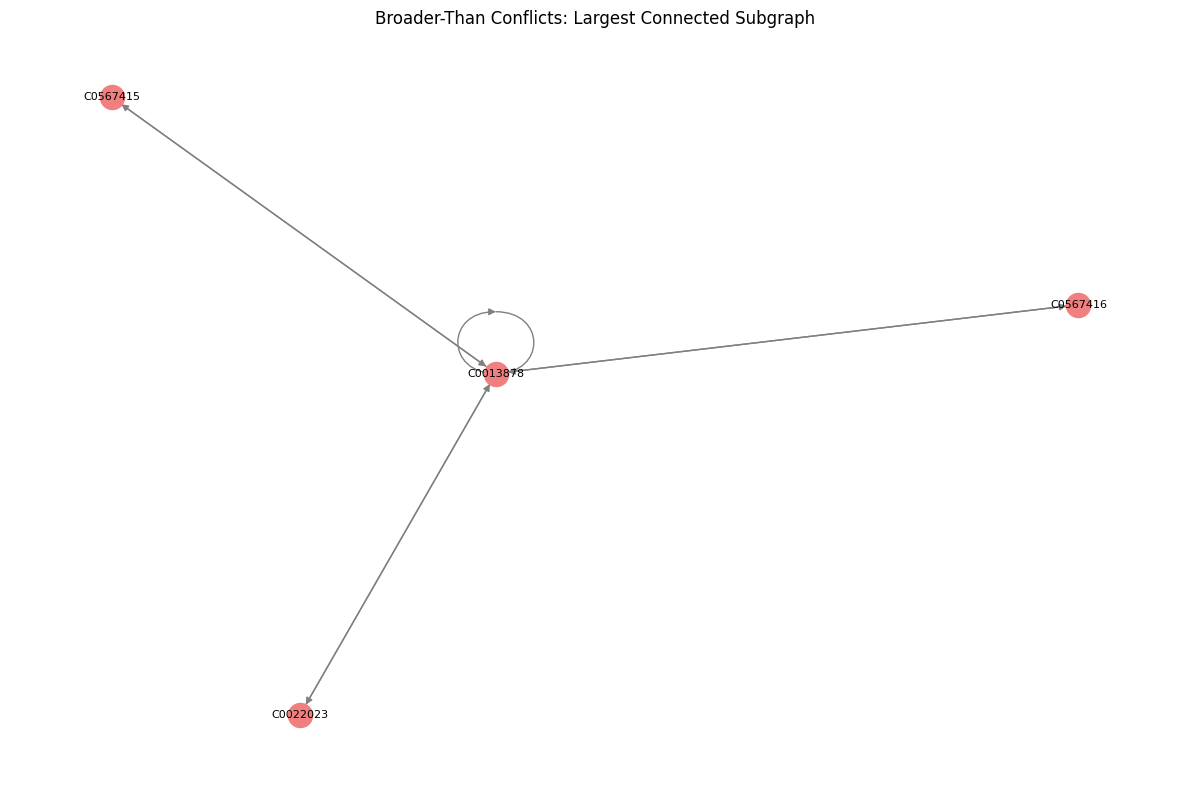

In [27]:
# Graph: Visualize all broader-than conflicts
import matplotlib.pyplot as plt

# Create a new graph with only the conflicting pairs
conflict_graph = nx.DiGraph()
conflict_graph.add_edges_from(bt_conflicts)

# Extract a subgraph with the largest connected component (for better visualization)
undirected_conflict = conflict_graph.to_undirected()
largest_cc = max(nx.connected_components(undirected_conflict), key=len)
subgraph = conflict_graph.subgraph(largest_cc)

# Draw the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='lightcoral')
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', arrows=True)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title("Broader-Than Conflicts: Largest Connected Subgraph")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
#LICIENCENOTE

#This project uses UMLS data under the terms of the UMLS Metathesaurus license.
#Redistribution of the dataset is not permitted.